In [1]:
# Montar el directorio que contiene los datos (IMPORTANTE: antes añadir la carpeta compartida a nuestro Drive!!)
# Comentar este bloque si la ejecución es en local
#from google.colab import drive
#drive.mount('/content/drive')

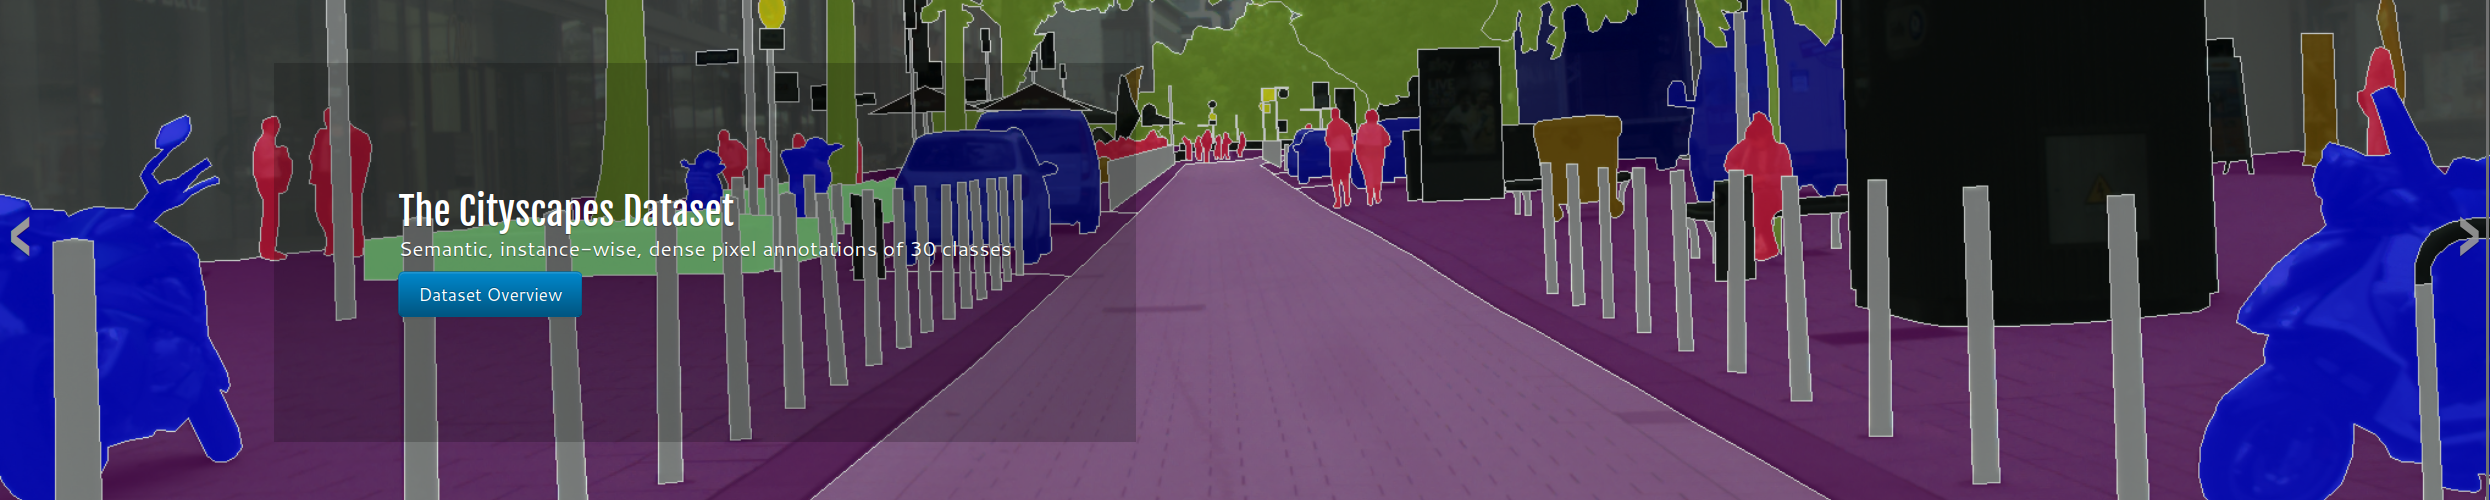

In [1]:
from PIL import Image
import shutil
import torch
import torchvision
from PIL import Image
import os
import numpy as np
import tensorflow as tf
import random
import torch
from torch import nn
from torch.nn import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tqdm
from time import time

2024-01-23 21:47:31.348715: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-23 21:47:31.350363: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 21:47:31.369574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 21:47:31.369593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 21:47:31.370336: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
def simplifyDirectories(in_dir, out_dir):
    citynames = os.listdir(in_dir)
    for cityname in citynames:
        for imgpath in os.listdir(os.path.join(in_dir, cityname)):
            code = imgpath.replace("_leftImg8bit.png", "")
            shutil.copy(os.path.join(in_dir, cityname, imgpath), os.path.join(in_dir, code+".png"))
            shutil.copy(os.path.join(out_dir, cityname, code + "_gtFine_color.png"), os.path.join(out_dir, code + "_color.png"))
            shutil.copy(os.path.join(out_dir, cityname, code + "_gtFine_labelIds.png"), os.path.join(out_dir, code + "_labels.png"))
        shutil.rmtree(os.path.join(in_dir, cityname))
        shutil.rmtree(os.path.join(out_dir, cityname))

In [3]:
simplifyDirectories(os.path.join("dataset", "leftImg8bit", "train"), os.path.join("dataset", "gtFine", "train"))
simplifyDirectories(os.path.join("dataset", "leftImg8bit", "val"), os.path.join("dataset", "gtFine", "val"))

In [9]:
counter = 0
mask_dir = os.path.join("dataset", "gtFine", "train")
for path in os.listdir(mask_dir):
    if "labels" in path:
        counter += 1
        array = np.array(Image.open(os.path.join(mask_dir, path)))
        if -1 in np.unique(array):
            print("found license plate")

In [10]:
counter

2975

In [11]:
counter = 0
mask_dir = os.path.join("dataset", "gtFine", "val")
for path in os.listdir(mask_dir):
    if "labels" in path:
        counter += 1
        array = np.array(Image.open(os.path.join(mask_dir, path)))
        if -1 in np.unique(array):
            print("found license plate")

In [12]:
counter

500

In [2]:
new_ids = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 0,
    5 : 0,
    6 : 0,
    7 : 1,
    8 : 2,
    9 : 0,
    10 : 0,
    11 : 3,
    12 : 4,
    13 : 5,
    14 : 0,
    15 : 0,
    16 : 0,
    17 : 6,
    18 : 0,
    19 : 7,
    20 : 8,
    21 : 9,
    22 : 10,
    23 : 11,
    24 : 12,
    25 : 13,
    26 : 14,
    27 : 15,
    28 : 16,
    29 : 0,
    30 : 0,
    31 : 17,
    32 : 18,
    33 : 19,
    -1 : 0,
}

In [57]:
COLORMAP = {
    0 : [0,0,0],
    1 : [128,64,128],
    2 : [244,35,232],
    3 : [70,70,70],
    4 : [102,102,156],
    5 : [190,153,153],
    6 : [153,153,153],
    7 : [250,170,30],
    8 : [220,220,0],
    9 : [107,142,35],
    10 : [152,251,152],
    11 : [70,130,180],
    12 : [220,20,60],
    13 : [255,0,0],
    14 : [0,0,142],
    15 : [0,0,70],
    16 : [0,60,100],
    17 : [0,80,100],
    18 : [0,0,230],
    19 : [119,11,32],
}

In [5]:
def clean_masks(mask_dir):
    for path in os.listdir(mask_dir):
        if "labels" in path:
            array = np.array(Image.open(os.path.join(mask_dir, path)))
            for key in new_ids:
                boolean = (array == key)
                if np.sum(boolean):
                    array[boolean] = new_ids[key]
            cleaned_mask = Image.fromarray(array)
            cleaned_mask.save(os.path.join(mask_dir, path.replace("_labels.png", "cleaned_labels.png")))

In [6]:
clean_masks(os.path.join("dataset", "gtFine", "train"))

In [7]:
clean_masks(os.path.join("dataset", "gtFine", "val"))

In [ ]:
# extract some samples from validation set to form a small test set

In [5]:
def extractCarvanaSamples(image_dir, mask_dir, new_image_dir, new_mask_dir, n_samples, shuffle=True):

    if os.path.exists(image_dir) and not os.path.isdir(image_dir):
        raise ValueError(f"The value passed to the parameter image_dir must be the path to an exiting. Received {image_dir}")
    elif not os.path.exists(image_dir):
        raise ValueError(f"The value passed to the paremeter image_dir must be the path to a directory containing Carvana images. Received {image_dir}")

    if os.path.exists(mask_dir) and not os.path.isdir(mask_dir):
        raise ValueError(f"The value passed to the parameter mask_dir must be the path to an exiting. Received {mask_dir}")
    elif not os.path.exists(mask_dir):
        raise ValueError(f"The value passed to the paremeter mask_dir must be the path to a directory containing Carvana masks. Received {mask_dir}")

    if os.path.exists(new_image_dir) and not os.path.isdir(new_image_dir):
        raise ValueError(f"The value passed to the parameter new_image_dir must be the path to an exiting or non existing directory. Received {new_image_dir}")
    elif not os.path.exists(new_image_dir):
        os.makedirs(new_image_dir)

    if os.path.exists(new_mask_dir) and not os.path.isdir(new_mask_dir):
        raise ValueError(f"The value passed to the parameter new_mask_dir must be the path to an exiting or non existing directory. Received {new_mask_dir}")
    elif not os.path.exists(new_mask_dir):
        os.makedirs(new_mask_dir)


    codes = [i.replace(".png", "") for i in os.listdir(image_dir)]
    if shuffle:
        random.shuffle(codes)

    if isinstance(n_samples, int):
        n_elements_to_extract = n_samples
    else:
        n_elements_to_extract = int(len(codes) * n_samples)

    to_extract = codes[:n_elements_to_extract]

    for code in to_extract:

        image_pathname = code + ".png"
    
        shutil.copy(os.path.join(image_dir, image_pathname), os.path.join(new_image_dir, image_pathname))
        
        mask_pathname = code + "_color.png"
        shutil.copy(os.path.join(mask_dir, mask_pathname), os.path.join(new_mask_dir, mask_pathname))
        mask_pathname = code + "_labels.png"
        shutil.copy(os.path.join(mask_dir, mask_pathname), os.path.join(new_mask_dir, mask_pathname))
        mask_pathname = code + "cleaned_labels.png"
        shutil.copy(os.path.join(mask_dir, mask_pathname), os.path.join(new_mask_dir, mask_pathname))

        #os.remove(os.path.join(image_dir, image_pathname))
        #os.remove(os.path.join(mask_dir, mask_pathname))

In [6]:
len(os.listdir(os.path.join("dataset", "leftImg8bit", "val")))

500

In [7]:
len(os.listdir(os.path.join("dataset", "gtFine", "val")))

1500

In [8]:
extractCarvanaSamples(
    image_dir=os.path.join("dataset", "leftImg8bit", "val"),
    mask_dir=os.path.join("dataset", "gtFine", "val"),
    new_image_dir=os.path.join("dataset", "leftImg8bit", "test"),
    new_mask_dir=os.path.join("dataset", "gtFine", "test"),
    n_samples=25,
    shuffle=True
)

In [11]:
len(os.listdir(os.path.join("dataset", "leftImg8bit", "test")))

25

In [12]:
len(os.listdir(os.path.join("dataset", "gtFine", "test")))

75